In [147]:
REFERENCE_SIZES = {
    'BusinessDepartment': {'height': 15.0, 'width': 40.0, 'reference_pixel_height': 450},
    'Library': {'height': 11.0, 'width': 45.0, 'reference_pixel_height': 450},
    'EEDepartment': {'height': 12.0, 'width': 50.0, 'reference_pixel_height': 450},
    'CivilDepartment': {'height': 14.0, 'width': 50.0, 'reference_pixel_height': 500},
    'OldCSDepartment': {'height': 15.0, 'width': 48.0, 'reference_pixel_height': 450},
    'NewCSDepartment': {'height': 16.0, 'width': 50.0, 'reference_pixel_height': 500}

}

In [148]:
def load_recognition_model():
    """Loads the trained landmark recognition model"""
    # Check if the model file exists and adjust path if needed
    # model_path = '/content/model/landmark_recognition_model.h5'
    model_path = 'model\landmark_recognition_model.h5'
    if not os.path.exists(model_path):
        # Try current directory
        model_path = 'landmark_recognition_model.h5'
        if not os.path.exists(model_path):
            # Ask user for the model path
            print("Model file not found. Please upload your model file:")
            uploaded = files.upload()
            model_path = list(uploaded.keys())[0]

    model = load_model(model_path)

    # Load annotations CSV - check if exists and adjust path
    annotations_path = "annotations/annotations.csv"
    if not os.path.exists(annotations_path):
        # Try current directory
        annotations_path = "annotations.csv"
        if not os.path.exists(annotations_path):
            print("Annotations CSV not found. Please upload your annotations file:")
            uploaded = files.upload()
            annotations_path = list(uploaded.keys())[0]

    df = pd.read_csv(annotations_path)

    # Encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(df['building_name'])

    # Get base model for feature extraction
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False

    return model, label_encoder, base_model

In [149]:
# Load and preprocess image for landmark recognition
def load_and_preprocess_image(img_path):
    """Load and preprocess image for the model"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

In [150]:
def recognize_landmark(img_path, model, label_encoder, base_model):
    """Recognize landmark in the given image"""
    # Preprocess image
    preprocessed_img, original_img = load_and_preprocess_image(img_path)

    # Extract features
    features = base_model.predict(preprocessed_img)

    # Predict building
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction[0])
    building_name = label_encoder.classes_[predicted_class]
    confidence = prediction[0][predicted_class]

    return building_name, confidence, original_img

In [151]:
def detect_building_boundaries(image_path):
    """
    Detect the boundaries of a building in the image
    Returns the bounding box coordinates and the building's height in pixels
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at path: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Dilate edges to connect broken lines
    dilated = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assuming it's the building)
    if not contours:
        return None, 0, img_rgb

    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Draw the bounding box on the image
    cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return (x, y, w, h), h, img_rgb

In [152]:
def estimate_distance_by_size(building_name, pixel_height):
    """
    Estimate the distance to a building based on its apparent size in pixels
    compared to a reference size.

    This uses the formula: distance = (reference_height_meters * reference_distance) / pixel_height
    """
    if building_name not in REFERENCE_SIZES:
        return None

    # Get reference measurements for this building
    reference_data = REFERENCE_SIZES[building_name]
    reference_height_m = reference_data['height']
    reference_pixel_height = reference_data['reference_pixel_height']

    # Calculate focal length from reference data
    # Assumes reference image was taken at a known distance (e.g., 10 meters)
    reference_distance = 10.0  # meters
    focal_length = (reference_pixel_height * reference_distance) / reference_height_m

    # Calculate distance using the focal length and current pixel height
    estimated_distance = (reference_height_m * focal_length) / pixel_height

    return estimated_distance


In [153]:
def estimate_distance_by_triangulation(img_path1, img_path2, baseline_distance):
    """
    Estimate distance using triangulation from two images taken at known distance apart

    Parameters:
    - img_path1: Path to first image
    - img_path2: Path to second image
    - baseline_distance: Distance between the two camera positions (in meters)

    Returns:
    - Estimated distance to the landmark
    """
    # Detect building in both images
    bbox1, height1, _ = detect_building_boundaries(img_path1)
    bbox2, height2, _ = detect_building_boundaries(img_path2)

    if bbox1 is None or bbox2 is None:
        return None

    # Calculate image centers (width)
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)
    img_center1 = img1.shape[1] / 2
    img_center2 = img2.shape[1] / 2

    # Calculate building centers in both images
    building_center1 = bbox1[0] + bbox1[2]/2
    building_center2 = bbox2[0] + bbox2[2]/2

    # Calculate parallax (difference in position)
    parallax1 = building_center1 - img_center1
    parallax2 = building_center2 - img_center2

    # Calculate change in parallax
    parallax_change = abs(parallax1 - parallax2)

    if parallax_change == 0:
        # Avoid division by zero
        return None

    # Calculate distance using triangulation formula
    # Distance = (baseline * focal_length) / parallax_change
    # Assuming focal_length is approximately image_width for simplicity
    focal_length = img1.shape[1]
    distance = (baseline_distance * focal_length) / parallax_change

    return distance

In [154]:
def visualize_results(img_rgb, building_name, confidence, distance):
    """Display the image with detected building and estimated distance"""
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(f"Detected: {building_name} (Confidence: {confidence:.2f})")
    plt.xlabel(f"Estimated Distance: {distance:.2f} meters")
    plt.axis('off')
    plt.show()

In [155]:
def estimate_location(building_name, distance, bearings=None):
    """
    Estimate user's location based on distance to a landmark and optional bearing
    For true localization, distances to multiple landmarks would be needed

    Parameters:
    - building_name: Name of the detected building
    - distance: Estimated distance to the building
    - bearings: Direction to the building in degrees (optional)

    Returns:
    - (x, y) coordinates on a campus map (arbitrary coordinate system)
    """
    # This is a simplified approach - in a real implementation, you would:
    # 1. Have a coordinate system for your campus map
    # 2. Know the fixed positions of each landmark/building
    # 3. Use distance + bearing to calculate user position

    # Example building coordinates on campus map (replace with your actual values)
    BUILDING_COORDINATES = {
        'BusinessDepartment': (100, 200),
        'EEDepartment': (280, 400),
        'Library': (300, 150),
        'OldCSDepartment': (250, 350),
        'CivilDepartment': (150, 300),
        'NewCSDepartment': (400, 250)
        
    }

    if building_name not in BUILDING_COORDINATES:
        return None

    building_x, building_y = BUILDING_COORDINATES[building_name]

    if bearings is None:
        # Without bearings, we can only estimate user is somewhere on a circle
        # around the building at the given distance
        # For visualization purposes, we'll pick a point south of the building
        angle_rad = math.radians(180)  # Default to south
    else:
        # Convert bearings to radians for calculation
        # Note: bearing is measured clockwise from north
        angle_rad = math.radians(bearings)

    # Calculate position (note: in a map, y increases downward typically)
    # We need to adjust the angle calculation as bearings are clockwise from north
    x = building_x - distance * math.sin(angle_rad)
    y = building_y + distance * math.cos(angle_rad)

    return x, y

In [156]:
# def visualize_location_on_map(user_location, building_name, building_coordinates):
#     """
#     Visualize the user's estimated location on a simple campus map
#     """
#     # Create a simple campus map
#     plt.figure(figsize=(10, 8))

#     # Plot buildings
#     for building, coords in building_coordinates.items():
#         plt.plot(coords[0], coords[1], 'bs', markersize=10)
#         plt.text(coords[0] + 5, coords[1] + 5, building, fontsize=8)

#     # Plot user location
#     if user_location:
#         plt.plot(user_location[0], user_location[1], 'ro', markersize=8)
#         plt.text(user_location[0] + 5, user_location[1] + 5, 'You are here', fontsize=8)

#     # Draw line connecting user to the detected building
#     if user_location and building_name in building_coordinates:
#         building_coords = building_coordinates[building_name]
#         plt.plot([user_location[0], building_coords[0]],
#                  [user_location[1], building_coords[1]],
#                  'g--', alpha=0.7)

#     plt.title('Campus Map with Your Estimated Location')
#     plt.xlabel('X coordinate')
#     plt.ylabel('Y coordinate')
#     plt.grid(True)
#     plt.axis('equal')
#     plt.show()
# def visualize_location_on_map(location, filename=None):
#     import folium
#     import os

#     m = folium.Map(location=location, zoom_start=18)
#     folium.Marker(location, tooltip="Estimated Location").add_to(m)

#     if not filename:
#         filename = f"map_{uuid.uuid4().hex}.html"

#     save_path = os.path.join("static", "maps", filename)
#     m.save(save_path)
#     return filename  # return just the filename (not full path)

def visualize_location_on_map(user_location, building_coordinates, detected_building=None, filename=None):
    import folium
    import os

    # Create the map centered at user location
    m = folium.Map(location=user_location, zoom_start=18)

    # Add marker for the user's estimated location
    folium.Marker(user_location, tooltip="Estimated Location", icon=folium.Icon(color="red")).add_to(m)

    # Plot all building markers
    for building_name, coords in building_coordinates.items():
        folium.Marker(
            location=coords,
            tooltip=building_name,
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

    # Optional: draw line from user to the detected building
    if detected_building and detected_building in building_coordinates:
        folium.PolyLine(locations=[user_location, building_coordinates[detected_building]],
                        color='green', weight=2.5, opacity=0.8).add_to(m)

    # Save map
    if not filename:
        filename = f"map_{uuid.uuid4().hex}.html"
    save_path = os.path.join("static", "maps", filename)
    m.save(save_path)

    return filename

In [157]:
pip install folium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [158]:
# def run_distance_estimation_pipeline( image_path,
#             model,
#             label_encoder,
#             base_model,
#             bearing):
#     """Run the complete pipeline for landmark recognition and distance estimation"""
#     # Load model and label encoder
#     print("Loading recognition model...")
#     model, label_encoder, base_model = load_recognition_model()
#     print("Model loaded successfully!")

#     # Upload images
#     # print("Please upload an image of a campus building:")
#     print("Please provide the path to an image of a campus building:")
#     img_path = image_path



#     # # Get the image path
#     # img_path = list(uploaded.keys())[0]

#     # Recognize landmark
#     print("Recognizing landmark...")
#     building_name, confidence, _ = recognize_landmark(img_path, model, label_encoder, base_model)
#     print(f"Recognized building: {building_name} with confidence {confidence:.2f}")

#     # Detect building boundaries
#     print("Detecting building boundaries...")
#     bbox, pixel_height, img_with_bbox = detect_building_boundaries(img_path)

#     if bbox is None:
#         print("Could not detect building boundaries. Please try a clearer image.")
#         return

#     # Estimate distance using object size
#     print("Estimating distance...")
#     distance = estimate_distance_by_size(building_name, pixel_height)

#     if distance is None:
#         print(f"No reference data available for {building_name}. Please add it to the REFERENCE_SIZES dictionary.")
#         return

#     print(f"Estimated distance to {building_name}: {distance:.2f} meters")

#     # Visualize results
#     visualize_results(img_with_bbox, building_name, confidence, distance)

#     # Optional: Triangulation method (requires two images)
#     print("Would you like to try the triangulation method? (y/n)")
#     triangulate = input()

#     if triangulate.lower() == 'y':
#         print("Please input path to a second image of the same building from a different position:")
#         # print("Please provide the path to an image of a campus building:")
#         second_img_path = input().strip().strip('"')


#         # second_img_path = list(second_img.keys())[0]

#         print("Enter the distance between the two positions where you took photos (in meters):")
#         baseline = float(input())

#         triangulation_distance = estimate_distance_by_triangulation(img_path, second_img_path, baseline)
#         if triangulation_distance:
#             print(f"Distance estimated by triangulation: {triangulation_distance:.2f} meters")
#         else:
#             print("Triangulation failed. Make sure both images clearly show the building.")

#     # Estimate user location
#     print("Estimating your location on campus...")
#     # Example building coordinates (replace with your actual campus map coordinates)
#     building_coordinates = {
#         'BusinessDepartment': (100, 200),
#         'EEDepartment': (150, 250),
#         'Library': (300, 150),
#         'OldCSDepartment': (130, 200),
#         'CivilDepartment': (150, 300),
#         'NewCSDepartment': (400, 350)
#     }

#     # For more accurate location, ask for bearing (direction)
#     use_bearing = input("Do you know the bearing (direction) to the building? (y/n): ")

#     if use_bearing.lower() == 'y':
#         print("Enter the bearing in degrees (0° is North, 90° is East, etc.):")
#         bearing = float(input())
#         user_location = estimate_location(building_name, distance, bearing)
#     else:
#         user_location = estimate_location(building_name, distance)

#     if user_location:
#         print(f"Your estimated location: {user_location}")
#         visualize_location_on_map(user_location, building_name)
#     else:
#         print("Could not estimate location. Make sure the building is in the reference database.")


def run_distance_estimation_pipeline(image_path, model, label_encoder, base_model, bearing=None):
    """Run the complete pipeline for landmark recognition and distance estimation"""
    try:
        # Load model and label encoder
        print("Loading recognition model...")
        model, label_encoder, base_model = load_recognition_model()
        print("Model loaded successfully!")

        # Recognize landmark
        print("Recognizing landmark...")
        building_name, confidence, _ = recognize_landmark(image_path, model, label_encoder, base_model)
        if building_name is None:
            print("Landmark recognition failed.")
            return None, None, None, None, None, None
        print(f"Recognized building: {building_name} with confidence {confidence:.2f}")

        # Detect building boundaries
        print("Detecting building boundaries...")
        bbox, pixel_height, img_with_bbox = detect_building_boundaries(image_path)
        if bbox is None:
            print("Could not detect building boundaries. Please try a clearer image.")
            return None, None, None, None, None, None

        # Estimate distance using object size
        print("Estimating distance...")
        distance = estimate_distance_by_size(building_name, pixel_height)
        if distance is None:
            print(f"No reference data available for {building_name}. Please add it to the REFERENCE_SIZES dictionary.")
            return None, None, None, None, None, None
        print(f"Estimated distance to {building_name}: {distance:.2f} meters")

        # Visualize results
        visualize_results(img_with_bbox, building_name, confidence, distance)

        # Optional: Triangulation method (requires two images)
        triangulation_distance = None
        triangulate = input("Would you like to try the triangulation method? (y/n): ").strip().lower()
        if triangulate == 'y':
            second_img_path = input("Please input path to a second image of the same building from a different position: ").strip()
            if not second_img_path:
                print("No second image provided.")
                return None, None, None, None, None, None
            try:
                baseline = float(input("Enter the distance between the two positions where you took photos (in meters): "))
            except ValueError:
                print("Invalid distance entered for baseline.")
                return None, None, None, None, None, None
            triangulation_distance = estimate_distance_by_triangulation(image_path, second_img_path, baseline)
            if triangulation_distance:
                print(f"Distance estimated by triangulation: {triangulation_distance:.2f} meters")
            else:
                print("Triangulation failed. Make sure both images clearly show the building.")

        # Estimate user location
        print("Estimating your location on campus...")
        building_coordinates = {
            'BusinessDepartment': (100, 200),
            'EEDepartment': (150, 250),
            'Library': (300, 150),
            'OldCSDepartment': (130, 200),
            'CivilDepartment': (150, 300),
            'NewCSDepartment': (400, 350)
        }

        user_location = None
        use_bearing = input("Do you know the bearing (direction) to the building? (y/n): ").strip().lower()
        if use_bearing == 'y':
            try:
                bearing = float(input("Enter the bearing in degrees (0° is North, 90° is East, etc.): ").strip())
                user_location = estimate_location(building_name, distance, bearing)
            except ValueError:
                print("Invalid bearing entered.")
                return None, None, None, None, None, None
        else:
            user_location = estimate_location(building_name, distance)

        if user_location:
            print(f"Your estimated location: {user_location}")
            visualize_location_on_map(user_location,building_coordinates, building_name)
        else:
            print("Could not estimate location. Make sure the building is in the reference database.")

        # Return the relevant information
        return building_name, confidence, bbox, pixel_height, distance, user_location

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None, None, None, None, None


In [159]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import math
import os
from flask import Flask, request, jsonify
import os
import uuid
import tempfile
import os

# Inside your Flask setup
STATIC_MAP_DIR = os.path.join(os.getcwd(), "static", "maps")
os.makedirs(STATIC_MAP_DIR, exist_ok=True)

app = Flask(__name__)

# Load models at startup
model, label_encoder, base_model = load_recognition_model()

In [160]:
# import os
# import uuid
# from flask import Flask, request, jsonify
# from werkzeug.utils import secure_filename

# UPLOAD_FOLDER = os.path.join(os.getcwd(), 'uploads')
# os.makedirs(UPLOAD_FOLDER, exist_ok=True)  # Create folder if it doesn't exist

# @app.route('/process-image', methods=['POST'])
# def process_image():
#     if 'image' not in request.files:
#         return jsonify({'error': 'No image file provided'}), 400

#     image_file = request.files['image']
#     if image_file.filename == '':
#         return jsonify({'error': 'Empty filename'}), 400

#     # Save uploaded image to the uploads/ folder
#     unique_filename = f"{uuid.uuid4().hex}_{secure_filename(image_file.filename)}"
#     image_path = os.path.join(UPLOAD_FOLDER, unique_filename)
#     image_file.save(image_path)

#     try:
#         data = request.form
#         bearing_input = data.get('bearing', None)
#         triangulate_input = data.get('triangulate', 'n').lower()
#         bearing = float(bearing_input) if bearing_input else None

#         building_name, confidence, bbox, pixel_height, distance, user_location = run_distance_estimation_pipeline(
#             image_path,
#             model,
#             label_encoder,
#             base_model,
#             bearing
#         )

#         triangulation_distance = None
#         if triangulate_input == 'y':
#             second_image = request.files.get('second_image', None)
#             baseline = data.get('baseline', None)
#             if second_image and baseline:
#                 second_filename = f"{uuid.uuid4().hex}_{secure_filename(second_image.filename)}"
#                 second_image_path = os.path.join(UPLOAD_FOLDER, second_filename)
#                 second_image.save(second_image_path)
#                 triangulation_distance = estimate_distance_by_triangulation(image_path, second_image_path, float(baseline))
#                 os.remove(second_image_path)

#         map_filename = visualize_location_on_map(user_location)
#         map_url = request.host_url + 'static/maps/' + map_filename
#         print(building_name,map_url)
#         return jsonify({
#             'building_name': building_name,
#             'confidence': confidence,
#             'bounding_box': bbox,
#             'pixel_height': pixel_height,
#             'distance': distance,
#             'user_location': user_location,
#             'triangulation_distance': triangulation_distance,
#             'map_url': map_url
#         })

#     finally:
#         # Optional cleanup: uncomment if you want to delete the image after processing
#         # if os.path.exists(image_path):
#         #     os.remove(image_path)
#         pass


import os
import uuid
from flask import Flask, request, jsonify
from werkzeug.utils import secure_filename

UPLOAD_FOLDER = os.path.join(os.getcwd(), 'uploads')
os.makedirs(UPLOAD_FOLDER, exist_ok=True)  # Create folder if it doesn't exist

@app.route('/process-image', methods=['POST'])
def process_image():
    if 'image' not in request.files:
        return jsonify({'error': 'No image file provided'}), 400

    image_file = request.files['image']
    if image_file.filename == '':
        return jsonify({'error': 'Empty filename'}), 400

    # Save uploaded image to the uploads/ folder
    unique_filename = f"{uuid.uuid4().hex}_{secure_filename(image_file.filename)}"
    image_path = os.path.join(UPLOAD_FOLDER, unique_filename)
    image_file.save(image_path)

    try:
        data = request.form
        bearing_input = data.get('bearing', None)
        triangulate_input = data.get('triangulate', 'n').lower()
        bearing = float(bearing_input) if bearing_input else None

        building_name, confidence, bbox, pixel_height, distance, user_location = run_distance_estimation_pipeline(
            image_path,
            model,
            label_encoder,
            base_model,
            bearing
        )

        # Convert non-serializable values to a standard Python type (float)
        distance = float(distance) if distance else None
        user_location = tuple(map(float, user_location)) if user_location else None  # Ensure it's a tuple of floats

        triangulation_distance = None
        if triangulate_input == 'y':
            second_image = request.files.get('second_image', None)
            baseline = data.get('baseline', None)
            if second_image and baseline:
                second_filename = f"{uuid.uuid4().hex}_{secure_filename(second_image.filename)}"
                second_image_path = os.path.join(UPLOAD_FOLDER, second_filename)
                second_image.save(second_image_path)
                triangulation_distance = estimate_distance_by_triangulation(image_path, second_image_path, float(baseline))
                os.remove(second_image_path)
        building_coordinates = {
            'BusinessDepartment': (100, 200),
            'EEDepartment': (150, 250),
            'Library': (300, 150),
            'OldCSDepartment': (130, 200),
            'CivilDepartment': (150, 300),
            'NewCSDepartment': (400, 350)
        }
        map_filename = visualize_location_on_map(user_location,building_coordinates)
        map_url = request.host_url + 'static/maps/' + map_filename
        print(building_name, map_url)

        return jsonify({
            'building_name': building_name,
            'confidence': str(confidence),
            'bounding_box': str(bbox),
            'pixel_height': str(pixel_height),
            'distance': str(distance),
            'user_location': str(user_location),
            'triangulation_distance': str(triangulation_distance),
            'map_url': str(map_url)
        })

    finally:
        # Optional cleanup: uncomment if you want to delete the image after processing
        # if os.path.exists(image_path):
        #     os.remove(image_path)
        pass


In [161]:
pip install pyngrok

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.7:5000
INFO:werkzeug:Press CTRL+C to quit


Loading recognition model...


Model loaded successfully!
Recognizing landmark...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Recognized building: CivilDepartment with confidence 1.00
Detecting building boundaries...
Estimating distance...
Estimated distance to CivilDepartment: 1.85 meters


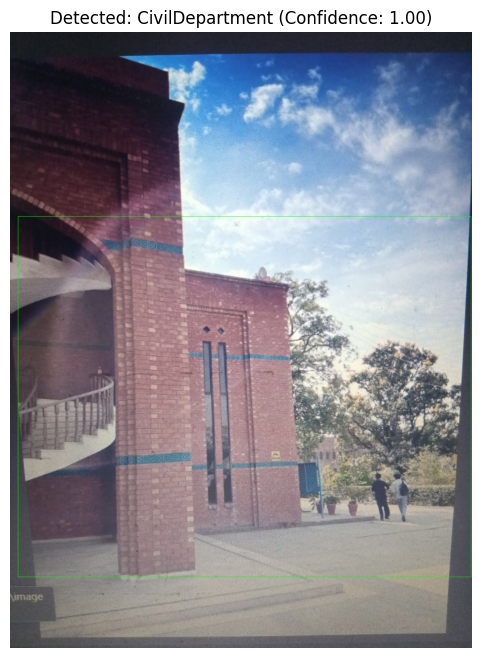

Estimating your location on campus...


INFO:werkzeug:192.168.1.11 - - [04/May/2025 00:59:30] "POST /process-image HTTP/1.1" 200 -


Your estimated location: (150.0, 298.1460882461995)
CivilDepartment http://192.168.1.7:5000/static/maps/map_a5783b36d8ac4febbc1aa6749a06d94a.html


INFO:werkzeug:192.168.1.7 - - [04/May/2025 00:59:47] "GET /static/maps/map_a5783b36d8ac4febbc1aa6749a06d94a.html HTTP/1.1" 200 -


In [ ]:
from flask import Flask
import nest_asyncio
from pyngrok import ngrok

nest_asyncio.apply()
app.run(host='0.0.0.0', port=5000, debug=False) 
